In [0]:
import autograd.numpy as np
import autograd
import matplotlib.pyplot as plt
%matplotlib inline

## Solving the Buckley-Leverett Equation with Python

This is the Buckley-Leverett Equation:
\begin{equation}
\phi\frac{\partial S_w}{\partial t} + q_t\frac{\partial f_w\left(S_w\right)}{\partial x} = 0,
\end{equation}

where $f_w\left(S_w\right) = \lambda_w/\lambda_t$, with $\lambda_\alpha = k_{r\alpha}/\mu_\alpha$ and $k_{rw} = k_{rw}^{max}S_w^{n_w}$ and $k_{ro} = k_{ro}^{max}(1-S_w)^{n_o}$

Here are the parameters of the solution:

In [0]:
nx = 10
dt = 100
tmax = 10.
length = 10.
dx = length/nx

grid = {'nx': nx, 'dx': dx, 'dt': dt, 'tmax': tmax, 'length': length}

phi = 0.1
muw = 3
muo = 1
nw = 3
no = 2
krwmax = 0.5
kromax = 1
q = 1e-6

params = {'phi':phi,'muw':muw, 'muo':muo, 'nw':nw, 'no':no, 'krwmax':krwmax, 'kromax':kromax, 'q':q}

Now let's implement the saturation functions

In [0]:
# def krw(sw,params):
#     return params['krwmax']*sw**params['nw']
# def kro(sw,params):
#     return params['kromax']*(1-sw)**params['no']
# def fw(sw,params):
#     lambdaw = krw(sw,params)/params['muw']
#     lambdao = kro(sw,params)/params['muo']
#     return (lambdaw/(lambdaw+lambdao))
def krw(sw,params):
    return params['krwmax']*sw
def kro(sw,params):
    return params['kromax']*(1-sw)
def fw(sw,params):
    lambdaw = krw(sw,params)/params['muw']
    lambdao = kro(sw,params)/params['muo']
    return (lambdaw/(lambdaw+lambdao))

Let's check how do they look like

In [0]:
swplot = np.linspace(0,1,20)

In [5]:
krw(swplot,params)

array([0.        , 0.02631579, 0.05263158, 0.07894737, 0.10526316,
       0.13157895, 0.15789474, 0.18421053, 0.21052632, 0.23684211,
       0.26315789, 0.28947368, 0.31578947, 0.34210526, 0.36842105,
       0.39473684, 0.42105263, 0.44736842, 0.47368421, 0.5       ])

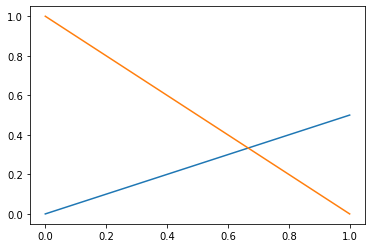

In [6]:
plt.plot(swplot,krw(swplot,params))
plt.plot(swplot,kro(swplot,params))

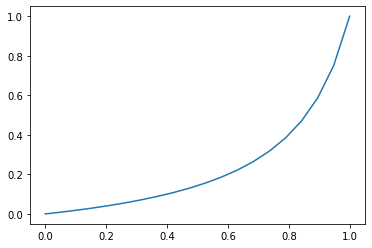

In [7]:
plt.plot(swplot,fw(swplot,params))

Now, integrating the above equation over a finite volume:

\begin{equation}
\phi\frac{\partial}{\partial t}\int_{\Delta x}S_wdx + q_t\int_{\Delta x}\frac{\partial f_w\left(S_w\right)}{\partial x}dx = 0 \Rightarrow \phi \Delta x\frac{dS_{wP}}{dt} + q_t\left[f_w\left(S_{we}^{\theta}\right)-f_w\left(S_{ww}^{\theta}\right)\right] = 0
\end{equation}

Now considering an upwind discretization scheme and an explicit forward in time discretization for the fluxes and transient terms, we arrive at:
\begin{equation}
\phi \Delta x\frac{S_{wP}^{n+1}-S_{wP}^{n}}{\Delta t} + q_t\left[f_w\left(S_{wP}^{n}\right)-f_w\left(S_{wW}^{n}\right)\right] = 0
\end{equation}

Rearranging:
\begin{equation}
S_{wP}^{n+1}-S_{wP}^{n} + \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n}\right)-f_w\left(S_{wW}^{n}\right)\right] = 0 \Rightarrow S_{wP}^{n+1} = S_{wP}^{n} - \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n}\right)-f_w\left(S_{wW}^{n}\right)\right]
\end{equation}

We consider a boundary condition of $S_w = 1$ for the left boundary of the domin. For the leftmost cell, we write:

\begin{equation}
S_{wP}^{n+1} = S_{wP}^{n} - \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n}\right)-f_w\left(1\right)\right] = S_{wP}^{n+1} = S_{wP}^{n} - \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n}\right)-1\right]
\end{equation}


Excellent! So let's initialize the saturation vector:

In [29]:
sw = np.zeros((nx,1))
sw.shape

(5, 1)

We define the factor

In [9]:
fac = params['q']*grid['dt']/(params['phi']*grid['dx'])
fac

0.0009999999999999998

We advance one step

In [30]:
for i in range(1000):
    # Boundary condition
    sw[0] = sw[0] - fac*(fw(sw[0],params)-1)
    # SwP
    swp = sw[1:]
    # SwW
    sww = sw[0:-1]
    # Updating Sw
    sw[1:] = swp - fac*(fw(swp,params)-fw(sww,params))
sw.shape

(5, 1)

(0, 10)

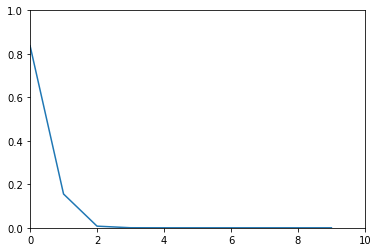

In [11]:
plt.plot(range(nx),sw)
plt.ylim((0,1))
plt.xlim((0,nx))

## Now the implicit formulation

\begin{equation}
\phi \Delta x\frac{S_{wP}^{n+1}-S_{wP}^{n}}{\Delta t} + q_t\left[f_w\left(S_{wP}^{n+1}\right)-f_w\left(S_{wW}^{n+1}\right)\right] = 0
\end{equation}

Rearranging:
\begin{equation}
S_{wP}^{n+1}-S_{wP}^{n} + \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n+1}\right)-f_w\left(S_{wW}^{n+1}\right)\right] = 0 
\end{equation}

We consider a boundary condition of $S_w = 1$ for the left boundary of the domin. For the leftmost cell, we write:

\begin{equation}
S_{wP}^{n+1} - S_{wP}^{n} + \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n+1}\right)-f_w\left(1\right)\right] = S_{wP}^{n+1} - S_{wP}^{n} + \frac{q_t\Delta t}{\phi \Delta x}\left[f_w\left(S_{wP}^{n+1}\right)-1\right] = 0
\end{equation}

Our goal is now to construct the residual of the equations...

In [0]:
nx = 5
def water_conservation_equation(sw,sw0):
    eq = 0*sw
    # print(eq.shape)
    sw0 = sw
    # Boundary condition
    eq[0]= sw[0] - sw0[0] - fac*(fw(sw[0],params)-1)
    # print(eq.shape)
    # Updating Sw
    # eq[1:] = sw[1:] - sw0[1:] - fac*(fw(sw[1:],params)-fw(sw[0:-1],params))
    # eq = np.ones((5, 1))
    return eq


In [60]:
sw[0]
sw0[0] - (fw(sw[0], params)  - 1) * fac

array([0.001])

In [83]:
sw = np.zeros((nx,1))
sw0 = sw
sw.shape

(5, 1)

In [85]:
water_conservation_equation(sw, sw0)

array([[0.001],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ]])

In [0]:
jac = autograd.jacobian(water_conservation_equation)

In [81]:
jacval = jac(sw, sw0)
jacval

array([[[-0.00016667],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]]])